In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Point, Polygon
import math
import pickle

In [2]:
anta_16 = pd.read_csv("pixel_data/Antananarivo_2016_all_pixels_data.csv")
anta_23 = pd.read_csv("pixel_data/Antananarivo_2023_all_pixels_data.csv")
abid_16 = pd.read_csv("pixel_data/Abidjan_2016_all_pixels_data.csv")
abid_23 = pd.read_csv("pixel_data/Abidjan_2023_all_pixels_data.csv")
lusa_16 = pd.read_csv("pixel_data/Lusaka_2016_all_pixels_data.csv")
lusa_23 = pd.read_csv("pixel_data/Lusaka_2023_all_pixels_data.csv")
yaou_16 = pd.read_csv("pixel_data/Yaounde_2016_all_pixels_data.csv")
yaou_23 = pd.read_csv("pixel_data/Yaounde_2023_all_pixels_data.csv")

In [3]:
# yaou_16[yaou_16['building_exist']==1].head(20)

In [4]:
datasets = [['Antananarivo','2016',anta_16,2573047.8],
           ['Antananarivo','2023',anta_23,3082163.4],
           ['Abidjan','2016',abid_16,4949308],
           ['Abidjan','2023',abid_23,6573035],
           ['Lusaka','2016',lusa_16,2492460],
           ['Lusaka','2023',lusa_23,2952857],
           ['Yaounde','2016',yaou_16,4065344],
           ['Yaounde','2023',yaou_23,5210992]]

In [27]:
for data in datasets:
    city = data[0]
    year = data[1]
    df = data[2]
    pop = data[3]
    df['building_volume1'] = df['building_volume']*100
    df['remoteness']=df['distance_to_center']/np.sqrt(pop)
    print(f'{city}_{year}_nonzero pixels =', (df['building_volume']!=0).sum())
    print(f'{city}_{year}_nonzero ratio =', ((df['building_volume']!=0).sum())/16008001)

Antananarivo_2016_nonzero pixels = 520964
Antananarivo_2016_nonzero ratio = 0.03254397597801249
Antananarivo_2023_nonzero pixels = 655672
Antananarivo_2023_nonzero ratio = 0.04095901793109583
Abidjan_2016_nonzero pixels = 1222140
Abidjan_2016_nonzero ratio = 0.07634557244218063
Abidjan_2023_nonzero pixels = 1694632
Abidjan_2023_nonzero ratio = 0.10586156260235116
Lusaka_2016_nonzero pixels = 836101
Lusaka_2016_nonzero ratio = 0.052230194138543594
Lusaka_2023_nonzero pixels = 1178080
Lusaka_2023_nonzero ratio = 0.07359319880102456
Yaounde_2016_nonzero pixels = 731551
Yaounde_2016_nonzero ratio = 0.04569908510125655
Yaounde_2023_nonzero pixels = 1043739
Yaounde_2023_nonzero ratio = 0.06520108288349058


Text(0.5, 1.0, 'Yaounde Building Volume Distribution')

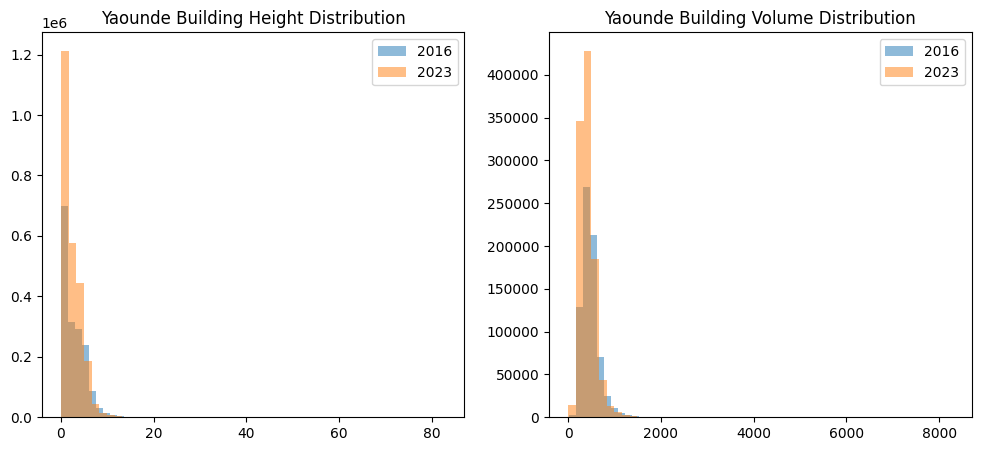

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(yaou_16[yaou_16['building_height'] > 0]['building_height'], bins=50, alpha=0.5, label='2016')
plt.hist(yaou_23[yaou_23['building_height'] > 0]['building_height'], bins=50, alpha=0.5, label='2023')
plt.legend(); plt.title("Yaounde Building Height Distribution")
plt.subplot(1,2,2)
plt.hist(yaou_16[yaou_16['building_volume1'] > 0]['building_volume1'], bins=50, alpha=0.5, label='2016')
plt.hist(yaou_23[yaou_23['building_volume1'] > 0]['building_volume1'], bins=50, alpha=0.5, label='2023')
plt.legend(); plt.title("Yaounde Building Volume Distribution")

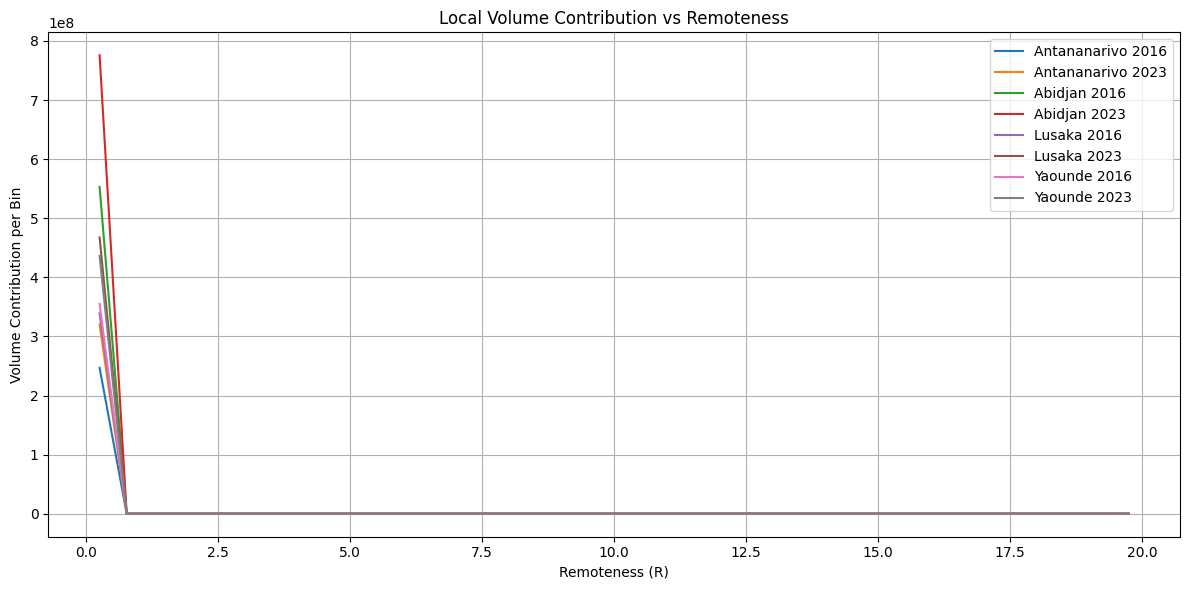

In [29]:
bins = np.linspace(0, 20, 40)

plt.figure(figsize=(12, 6))

for data in datasets:
    city, year, df, pop = data

    df['remoteness'] = df['distance_to_center'] / np.sqrt(pop)
    df['building_volume1'] = df['building_volume'] * 100
    df['volume_contribution'] = df['building_volume1']

    df_nonzero = df[df['building_volume1'] > 0].copy()
    df_nonzero['bin'] = pd.cut(df_nonzero['remoteness'], bins)

    volume_density = df_nonzero.groupby('bin', observed=False)['building_volume1'].mean()
    pixel_count = df_nonzero.groupby('bin').size()
    contribution = volume_density * pixel_count
    contribution.plot(label=year)

    # grouped = df_nonzero.groupby('bin', observed=False)['volume_contribution'].sum()
    # bin_centers = [interval.mid for interval in grouped.index]

    # plt.plot(bin_centers, grouped.values, label=f"{city} {year}")

plt.xlabel("Remoteness (R)")
plt.ylabel("Volume Contribution per Bin")
plt.title("Local Volume Contribution vs Remoteness")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

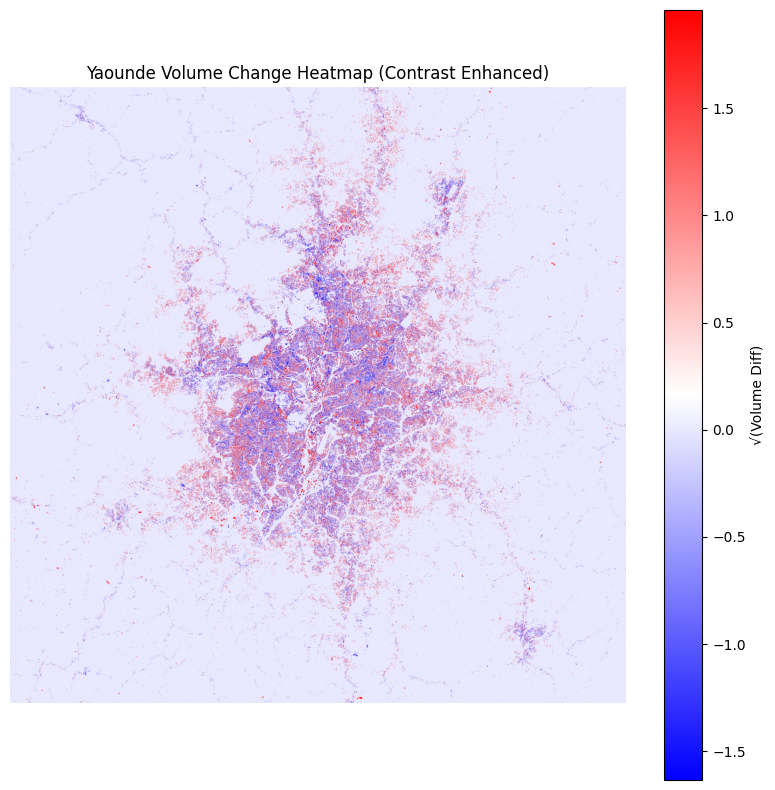

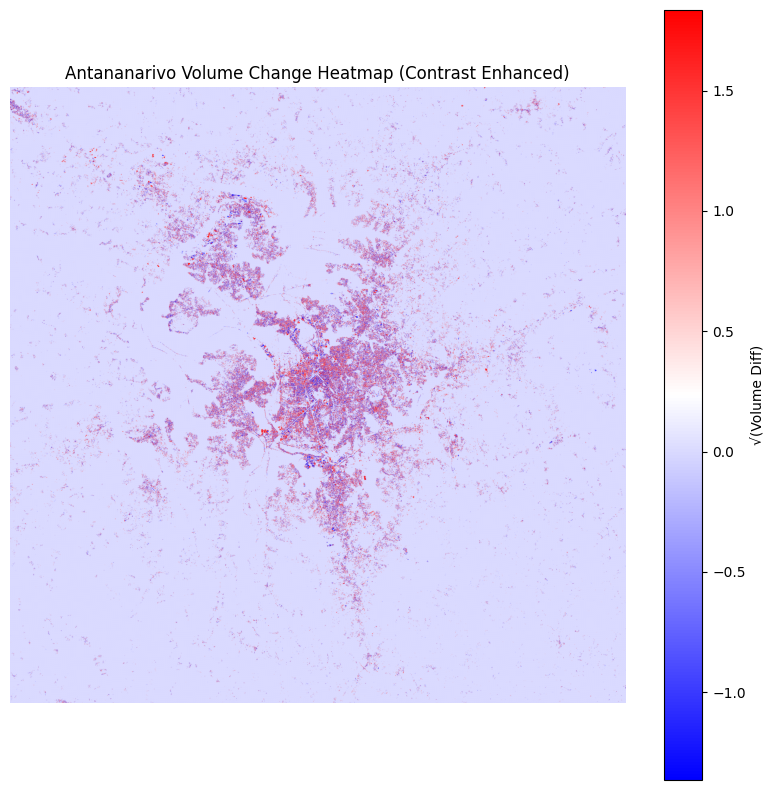

In [18]:
for city in ['Yaounde', 'Antananarivo']:
    df_16 = [d[2] for d in datasets if d[0] == city and d[1] == '2016'][0]
    df_23 = [d[2] for d in datasets if d[0] == city and d[1] == '2023'][0]

    df_16 = df_16[['row', 'col', 'building_volume']].rename(columns={'building_volume': 'volume_2016'})
    df_23 = df_23[['row', 'col', 'building_volume']].rename(columns={'building_volume': 'volume_2023'})

    df_merge = pd.merge(df_16, df_23, on=['row', 'col'])
    df_merge['volume_diff'] = df_merge['volume_2023'] - df_merge['volume_2016']

    # 非线性放大微小变化
    df_merge['volume_diff'] = np.sign(df_merge['volume_diff']) * np.sqrt(np.abs(df_merge['volume_diff']))

    heatmap = df_merge.pivot(index='row', columns='col', values='volume_diff')

    # 使用 1%-99% 百分位控制颜色对比度
    vmax = np.nanpercentile(heatmap.values, 99)
    vmin = np.nanpercentile(heatmap.values, 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(heatmap.values, cmap='bwr', vmin=vmin, vmax=vmax)
    plt.colorbar(label="√(Volume Diff)")
    plt.title(f"{city} Volume Change Heatmap (Contrast Enhanced)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

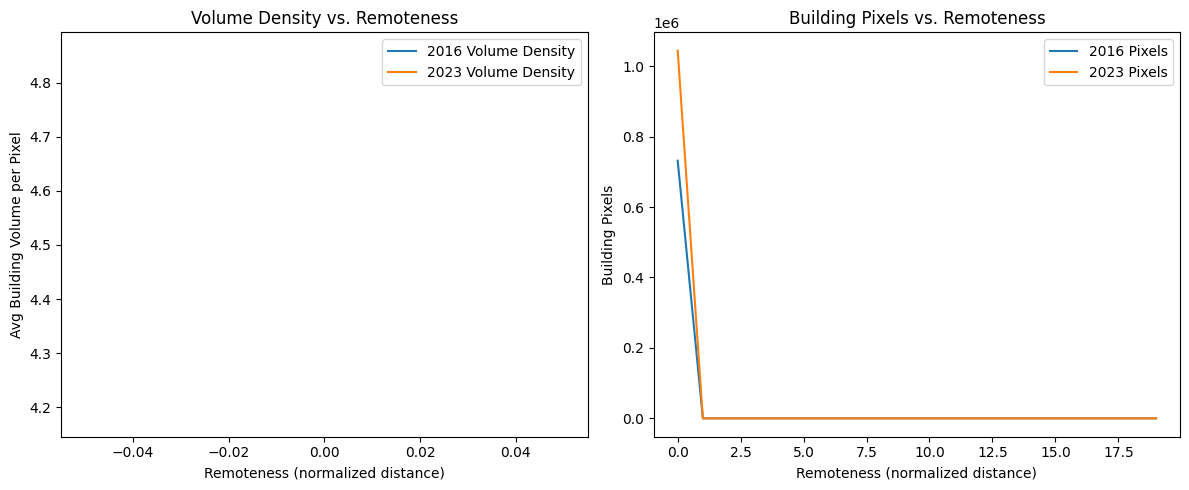

In [19]:
bin_width = 1
max_remoteness = 20
bins = np.arange(0, max_remoteness + bin_width, bin_width)

yaou_16['bin'] = pd.cut(yaou_16['remoteness'], bins=bins, labels=bins[:-1])
yaou_23['bin'] = pd.cut(yaou_23['remoteness'], bins=bins, labels=bins[:-1])
def summarize(df, label):
    subset = df[df['building_exist'] == 1]
    grouped = subset.groupby('bin', observed = False)
    summary = grouped.agg({
        'building_volume': ['mean', 'sum', 'count']
    })
    summary.columns = [f'{label}_density', f'{label}_total_volume', f'{label}_pixel_count']
    return summary

summary_16 = summarize(yaou_16, 'y16')
summary_23 = summarize(yaou_23, 'y23')

summary = pd.concat([summary_16, summary_23], axis=1).reset_index()
summary['bin'] = summary['bin'].astype(float)
plt.figure(figsize=(12, 5))

# 平均密度
plt.subplot(1, 2, 1)
plt.plot(summary['bin'], summary['y16_density'], label='2016 Volume Density')
plt.plot(summary['bin'], summary['y23_density'], label='2023 Volume Density')
plt.xlabel('Remoteness (normalized distance)')
plt.ylabel('Avg Building Volume per Pixel')
plt.title('Volume Density vs. Remoteness')
plt.legend()

# 像素数量
plt.subplot(1, 2, 2)
plt.plot(summary['bin'], summary['y16_pixel_count'], label='2016 Pixels')
plt.plot(summary['bin'], summary['y23_pixel_count'], label='2023 Pixels')
plt.xlabel('Remoteness (normalized distance)')
plt.ylabel('Building Pixels')
plt.title('Building Pixels vs. Remoteness')
plt.legend()

plt.tight_layout()
plt.show()